In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
#from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

#x_train = x_train.reshape((num_train, 28, 28, 1))
#x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (50000, 32, 32, 3)
Step 2 x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4137    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  4398    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1727    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3981    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  3865    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  1943    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4960    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4824    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  2531    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2368    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1953    Number of Trainin

In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['L{}_layer{}_w'.format(i,layer_index)][0] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][0])
                globals()['L{}_layer{}_w'.format(i,layer_index)][1] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][1])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])

#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5212 - accuracy: 0.4433
15/15 - 0s - loss: 1.5382 - accuracy: 0.4433
15/15 - 0s - loss: 1.7903 - accuracy: 0.3172
15/15 - 0s - loss: 1.7183 - accuracy: 0.3382
15/15 - 0s - loss: 1.5311 - accuracy: 0.4790
15/15 - 0s - loss: 1.7179 - accuracy: 0.3845
15/15 - 0s - loss: 1.5335 - accuracy: 0.4496
15/15 - 0s - loss: 1.5821 - accuracy: 0.4244
15/15 - 0s - loss: 1.7185 - accuracy: 0.3866
15/15 - 0s - loss: 1.6733 - accuracy: 0.3655
15/15 - 0s - loss: 1.6837 - accuracy: 0.3887
15/15 - 0s - loss: 1.5288 - accuracy: 0.4349
15/15 - 0s - loss: 1.7692 - accuracy: 0.3529
15/15 - 0s - loss: 1.7265 - accuracy: 0.4013
15/15 - 0s - loss: 1.7146 - accuracy: 0.3845
15/15 - 0s - loss: 1.9447 - accuracy: 0.3088
15/15 - 0s - loss: 1.5018 - accuracy: 0.4664
15/15 - 0s - loss: 1.5978 - accuracy: 0.4181
15/15 - 0s - loss: 1.5047 - accuracy: 0.4433
15/15 - 0s - loss: 1.6813 - accuracy: 0.3887
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-f5f597c82df1>:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
<ipython-input-7-f5f597c82df1>:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(glob

In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, int(len(list(x_train_range))/local) ) #변동 사항
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함

        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        best_Sil_score_c = []
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
            
        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        

        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])
                    
                    globals()['L{}_layer{}_w'.format(i,layer_index)][0] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][0])
                    globals()['L{}_layer{}_w'.format(i,layer_index)][1] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][1])
                    
                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        
        sum_for_var_w,sum_for_var_b = 0, 0
        for sps in range(3):
            sum_for_var_w = sum_for_var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][0]
            sum_for_var_b = sum_for_var_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][1] 
        
        sum_for_var_w = sum_for_var_w/(3)
        sum_for_var_b = sum_for_var_b/(3)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(sum_for_var_w))
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(sum_for_var_b))
  

        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.8530 - accuracy: 0.2794
15/15 - 0s - loss: 1.9536 - accuracy: 0.2626
15/15 - 0s - loss: 1.9092 - accuracy: 0.2437
15/15 - 0s - loss: 1.8996 - accuracy: 0.2773
15/15 - 0s - loss: 1.8917 - accuracy: 0.2521
15/15 - 0s - loss: 1.9974 - accuracy: 0.2248
15/15 - 0s - loss: 2.0078 - accuracy: 0.2458
15/15 - 0s - loss: 1.9823 - accuracy: 0.2227
15/15 - 0s - loss: 1.8502 - accuracy: 0.2584
15/15 - 0s - loss: 1.9954 - accuracy: 0.2416
15/15 - 0s - loss: 1.8866 - accuracy: 0.2899
15/15 - 0s - loss: 1.9349 - accuracy: 0.2773
15/15 - 0s - loss: 2.0101 - accuracy: 0.2416
15/15 - 0s - loss: 1.9458 - accuracy: 0.2626
15/15 - 0s - loss: 1.9095 - accuracy: 0.3004
15/15 - 0s - loss: 1.8764 - accuracy: 0.2689
15/15 - 0s - loss: 1.6591 - accuracy: 0.3613
15/15 - 0s - loss: 1.9882 - accuracy: 0.2332
15/15 - 0s - loss: 2.2162 - accuracy: 0.1765
15/15 - 0s - loss: 2.0832 - 

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!
2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.9216 - accuracy: 0.2605
15/15 - 0s - loss: 1.8095 - accuracy: 0.3172
15/15 - 0s - loss: 1.9527 - accuracy: 0.2815
15/15 - 0s - loss: 1.7878 - accuracy: 0.3592
15/15 - 0s - loss: 1.7307 - accuracy: 0.3487
15/15 - 0s - loss: 1.9089 - accuracy: 0.2899
15/15 - 0s - loss: 1.8090 - accuracy: 0.3046
15/15 - 0s - loss: 1.8053 - accuracy: 0.3361
15/15 - 0s - loss: 1.7546 - accuracy: 0.3445
15/15 - 0s - loss: 1.8018 - accuracy: 0.3109
15/15 - 0s - loss: 1.8254 - accuracy: 0.3004
15/15 - 0s - loss: 1.8894 - accuracy: 0.2941
15/15 - 0s - loss: 1.7302 - accuracy: 0.3298
15/15 - 0s - loss: 1.7676 - accuracy: 0.3613
15/15 - 0s - loss: 1.7260 - accuracy: 0.3424
15/15 - 0s - loss: 1.8102 - accuracy: 0.2983
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!
3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5281 - accuracy: 0.4454
15/15 - 0s - loss: 1.7439 - accuracy: 0.3340
15/15 - 0s - loss: 1.9373 - accuracy: 0.3046
15/15 - 0s - loss: 1.8096 - accuracy: 0.3046
15/15 - 0s - loss: 1.6274 - accuracy: 0.3676
15/15 - 0s - loss: 1.8615 - accuracy: 0.3109
15/15 - 0s - loss: 1.7171 - accuracy: 0.3824
15/15 - 0s - loss: 1.7161 - accuracy: 0.3382
15/15 - 0s - loss: 1.7226 - accuracy: 0.3067
15/15 - 0s - loss: 1.7059 - accuracy: 0.3718
15/15 - 0s - loss: 1.7772 - accuracy: 0.3550
15/15 - 0s - loss: 1.7070 - accuracy: 0.3950
15/15 - 0s - loss: 1.7025 - accuracy: 0.4034
15/15 - 0s - loss: 1.6726 - accuracy: 0.3866
15/15 - 0s - loss: 1.7758 - accuracy: 0.3508
15/15 - 0s - loss: 1.8469 - accuracy: 0.2710
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!
4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.6550 - accuracy: 0.4034
15/15 - 0s - loss: 1.6911 - accuracy: 0.3655
15/15 - 0s - loss: 1.7146 - accuracy: 0.3739
15/15 - 0s - loss: 1.7023 - accuracy: 0.3403
15/15 - 0s - loss: 1.7008 - accuracy: 0.3529
15/15 - 0s - loss: 1.7452 - accuracy: 0.3613
15/15 - 0s - loss: 1.5717 - accuracy: 0.4328
15/15 - 0s - loss: 1.6495 - accuracy: 0.4055
15/15 - 0s - loss: 1.7056 - accuracy: 0.3550
15/15 - 0s - loss: 1.7414 - accuracy: 0.3466
15/15 - 0s - loss: 1.6818 - accuracy: 0.3550
15/15 - 0s - loss: 1.8021 - accuracy: 0.3214
15/15 - 0s - loss: 1.6609 - accuracy: 0.3718
15/15 - 0s - loss: 1.6827 - accuracy: 0.3634
15/15 - 0s - loss: 1.7696 - accuracy: 0.3529
15/15 - 0s - loss: 1.6103 - accuracy: 0.4118
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5419 - accuracy: 0.4307
15/15 - 0s - loss: 1.6984 - accuracy: 0.3824
15/15 - 0s - loss: 1.6882 - accuracy: 0.3929
15/15 - 0s - loss: 1.6649 - accuracy: 0.3782
15/15 - 0s - loss: 1.7408 - accuracy: 0.3845
15/15 - 0s - loss: 1.7233 - accuracy: 0.3529
15/15 - 0s - loss: 1.6374 - accuracy: 0.3929
15/15 - 0s - loss: 1.6854 - accuracy: 0.3866
15/15 - 0s - loss: 1.6977 - accuracy: 0.3718
15/15 - 0s - loss: 1.5788 - accuracy: 0.4034
15/15 - 0s - loss: 1.6607 - accuracy: 0.3761
15/15 - 0s - loss: 1.6670 - accuracy: 0.3613
15/15 - 0s - loss: 1.6831 - accuracy: 0.3697
15/15 - 0s - loss: 1.6910 - accuracy: 0.3908
15/15 - 0s - loss: 1.6234 - accuracy: 0.4034
15/15 - 0s - loss: 1.6369 - accuracy: 0.3866
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!
6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5672 - accuracy: 0.4055
15/15 - 0s - loss: 1.5633 - accuracy: 0.4433
15/15 - 0s - loss: 1.6139 - accuracy: 0.4454
15/15 - 0s - loss: 1.5356 - accuracy: 0.4181
15/15 - 0s - loss: 1.5741 - accuracy: 0.3676
15/15 - 0s - loss: 1.6988 - accuracy: 0.3550
15/15 - 0s - loss: 1.7049 - accuracy: 0.4097
15/15 - 0s - loss: 1.6285 - accuracy: 0.3971
15/15 - 0s - loss: 1.9233 - accuracy: 0.3508
15/15 - 0s - loss: 1.6214 - accuracy: 0.3529
15/15 - 0s - loss: 1.6767 - accuracy: 0.3992
15/15 - 0s - loss: 1.5411 - accuracy: 0.4286
15/15 - 0s - loss: 1.6032 - accuracy: 0.3676
15/15 - 0s - loss: 1.6627 - accuracy: 0.4034
15/15 - 0s - loss: 1.5201 - accuracy: 0.4349
15/15 - 0s - loss: 1.5530 - accuracy: 0.3929
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5094 - accuracy: 0.4496
15/15 - 0s - loss: 1.5831 - accuracy: 0.4223
15/15 - 0s - loss: 1.6139 - accuracy: 0.4118
15/15 - 0s - loss: 1.5314 - accuracy: 0.4664
15/15 - 0s - loss: 1.6343 - accuracy: 0.3803
15/15 - 0s - loss: 1.5392 - accuracy: 0.4475
15/15 - 0s - loss: 1.5018 - accuracy: 0.4454
15/15 - 0s - loss: 1.5935 - accuracy: 0.4139
15/15 - 0s - loss: 1.5812 - accuracy: 0.4034
15/15 - 0s - loss: 1.5502 - accuracy: 0.4181
15/15 - 0s - loss: 1.6390 - accuracy: 0.4076
15/15 - 0s - loss: 1.5013 - accuracy: 0.4475
15/15 - 0s - loss: 1.7260 - accuracy: 0.3782
15/15 - 0s - loss: 1.6617 - accuracy: 0.3866
15/15 - 0s - loss: 1.5691 - accuracy: 0.4181
15/15 - 0s - loss: 1.5598 - accuracy: 0.4055
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!
8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5588 - accuracy: 0.4433
15/15 - 0s - loss: 1.4577 - accuracy: 0.4832
15/15 - 0s - loss: 1.5702 - accuracy: 0.4265
15/15 - 0s - loss: 1.7008 - accuracy: 0.3697
15/15 - 0s - loss: 1.5535 - accuracy: 0.4496
15/15 - 0s - loss: 1.5968 - accuracy: 0.3992
15/15 - 0s - loss: 1.4339 - accuracy: 0.4853
15/15 - 0s - loss: 1.4606 - accuracy: 0.4727
15/15 - 0s - loss: 1.5219 - accuracy: 0.4370
15/15 - 0s - loss: 1.4791 - accuracy: 0.4853
15/15 - 0s - loss: 1.6154 - accuracy: 0.3971
15/15 - 0s - loss: 1.6958 - accuracy: 0.3697
15/15 - 0s - loss: 1.5353 - accuracy: 0.4412
15/15 - 0s - loss: 1.6465 - accuracy: 0.3866
15/15 - 0s - loss: 1.5611 - accuracy: 0.4370
15/15 - 0s - loss: 1.3951 - accuracy: 0.4748
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4784 - accuracy: 0.4370
15/15 - 0s - loss: 1.5486 - accuracy: 0.4307
15/15 - 0s - loss: 1.5050 - accuracy: 0.4391
15/15 - 0s - loss: 1.6880 - accuracy: 0.3739
15/15 - 0s - loss: 1.5301 - accuracy: 0.4160
15/15 - 0s - loss: 1.4516 - accuracy: 0.4538
15/15 - 0s - loss: 1.4129 - accuracy: 0.4832
15/15 - 0s - loss: 1.4957 - accuracy: 0.4601
15/15 - 0s - loss: 1.4921 - accuracy: 0.4580
15/15 - 0s - loss: 1.4443 - accuracy: 0.4664
15/15 - 0s - loss: 1.5456 - accuracy: 0.4664
15/15 - 0s - loss: 1.5192 - accuracy: 0.4643
15/15 - 0s - loss: 1.5087 - accuracy: 0.4685
15/15 - 0s - loss: 1.5609 - accuracy: 0.4265
15/15 - 0s - loss: 1.5810 - accuracy: 0.4244
15/15 - 0s - loss: 1.5232 - accuracy: 0.4496
15/15 - 0s - loss

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!
10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4203 - accuracy: 0.4874
15/15 - 0s - loss: 1.6670 - accuracy: 0.4160
15/15 - 0s - loss: 1.4937 - accuracy: 0.4496
15/15 - 0s - loss: 1.5482 - accuracy: 0.4349
15/15 - 0s - loss: 1.4760 - accuracy: 0.4328
15/15 - 0s - loss: 1.4722 - accuracy: 0.4769
15/15 - 0s - loss: 1.4278 - accuracy: 0.4769
15/15 - 0s - loss: 1.4136 - accuracy: 0.4748
15/15 - 0s - loss: 1.4310 - accuracy: 0.4664
15/15 - 0s - loss: 1.5154 - accuracy: 0.4643
15/15 - 0s - loss: 1.5971 - accuracy: 0.4349
15/15 - 0s - loss: 1.4812 - accuracy: 0.4580
15/15 - 0s - loss: 1.5763 - accuracy: 0.4328
15/15 - 0s - loss: 1.5746 - accuracy: 0.4181
15/15 - 0s - loss: 1.3492 - accuracy: 0.5147
15/15 - 0s - loss: 1.5581 - accuracy: 0.4433
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!
11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3810 - accuracy: 0.4979
15/15 - 0s - loss: 1.4025 - accuracy: 0.5084
15/15 - 0s - loss: 1.4782 - accuracy: 0.4874
15/15 - 0s - loss: 1.5027 - accuracy: 0.4622
15/15 - 0s - loss: 1.3414 - accuracy: 0.5000
15/15 - 0s - loss: 1.4579 - accuracy: 0.4916
15/15 - 0s - loss: 1.5195 - accuracy: 0.4643
15/15 - 0s - loss: 1.4412 - accuracy: 0.4622
15/15 - 0s - loss: 1.4144 - accuracy: 0.4727
15/15 - 0s - loss: 1.5281 - accuracy: 0.4601
15/15 - 0s - loss: 1.4313 - accuracy: 0.4664
15/15 - 0s - loss: 1.3953 - accuracy: 0.4727
15/15 - 0s - loss: 1.5089 - accuracy: 0.4643
15/15 - 0s - loss: 1.6186 - accuracy: 0.3971
15/15 - 0s - loss: 1.4975 - accuracy: 0.4433
15/15 - 0s - loss: 1.6661 - accuracy: 0.4370
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!
12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4065 - accuracy: 0.4895
15/15 - 0s - loss: 1.5457 - accuracy: 0.4454
15/15 - 0s - loss: 1.4748 - accuracy: 0.4769
15/15 - 0s - loss: 1.4360 - accuracy: 0.4895
15/15 - 0s - loss: 1.3971 - accuracy: 0.4853
15/15 - 0s - loss: 1.4194 - accuracy: 0.4748
15/15 - 0s - loss: 1.4783 - accuracy: 0.4685
15/15 - 0s - loss: 1.4412 - accuracy: 0.4748
15/15 - 0s - loss: 1.4389 - accuracy: 0.5000
15/15 - 0s - loss: 1.4603 - accuracy: 0.4979
15/15 - 0s - loss: 1.4565 - accuracy: 0.4622
15/15 - 0s - loss: 1.3807 - accuracy: 0.4706
15/15 - 0s - loss: 1.4898 - accuracy: 0.4685
15/15 - 0s - loss: 1.4731 - accuracy: 0.4790
15/15 - 0s - loss: 1.4432 - accuracy: 0.4874
15/15 - 0s - loss: 1.4541 - accuracy: 0.4391
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3813 - accuracy: 0.4895
15/15 - 0s - loss: 1.5056 - accuracy: 0.4601
15/15 - 0s - loss: 1.3508 - accuracy: 0.5252
15/15 - 0s - loss: 1.5055 - accuracy: 0.4559
15/15 - 0s - loss: 1.5787 - accuracy: 0.4412
15/15 - 0s - loss: 1.5157 - accuracy: 0.4685
15/15 - 0s - loss: 1.4029 - accuracy: 0.5210
15/15 - 0s - loss: 1.4505 - accuracy: 0.4769
15/15 - 0s - loss: 1.3627 - accuracy: 0.4937
15/15 - 0s - loss: 1.3425 - accuracy: 0.5231
15/15 - 0s - loss: 1.4604 - accuracy: 0.4958
15/15 - 0s - loss: 1.3784 - accuracy: 0.5042
15/15 - 0s - loss: 1.4661 - accuracy: 0.4685
15/15 - 0s - loss: 1.5159 - accuracy: 0.4328
15/15 - 0s - loss: 1.5262 - accuracy: 0.4412
15/15 - 0s - loss: 1.4194 - accuracy: 0.4958
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!
14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5154 - accuracy: 0.5021
15/15 - 0s - loss: 1.4318 - accuracy: 0.4748
15/15 - 0s - loss: 1.5087 - accuracy: 0.4916
15/15 - 0s - loss: 1.5182 - accuracy: 0.4622
15/15 - 0s - loss: 1.3533 - accuracy: 0.5231
15/15 - 0s - loss: 1.3665 - accuracy: 0.5042
15/15 - 0s - loss: 1.6063 - accuracy: 0.4832
15/15 - 0s - loss: 1.4375 - accuracy: 0.4979
15/15 - 0s - loss: 1.4475 - accuracy: 0.4958
15/15 - 0s - loss: 1.3910 - accuracy: 0.4832
15/15 - 0s - loss: 1.4062 - accuracy: 0.4874
15/15 - 0s - loss: 1.4724 - accuracy: 0.4727
15/15 - 0s - loss: 1.3475 - accuracy: 0.5126
15/15 - 0s - loss: 1.5580 - accuracy: 0.4517
15/15 - 0s - loss: 1.4184 - accuracy: 0.4832
15/15 - 0s - loss: 1.3957 - accuracy: 0.4937
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3549 - accuracy: 0.5336
15/15 - 0s - loss: 1.3928 - accuracy: 0.5294
15/15 - 0s - loss: 1.3305 - accuracy: 0.5189
15/15 - 0s - loss: 1.4970 - accuracy: 0.4853
15/15 - 0s - loss: 1.4363 - accuracy: 0.4790
15/15 - 0s - loss: 1.2948 - accuracy: 0.5147
15/15 - 0s - loss: 1.4277 - accuracy: 0.4874
15/15 - 0s - loss: 1.4326 - accuracy: 0.5063
15/15 - 0s - loss: 1.3792 - accuracy: 0.5126
15/15 - 0s - loss: 1.4573 - accuracy: 0.4958
15/15 - 0s - loss: 1.5361 - accuracy: 0.4433
15/15 - 0s - loss: 1.3241 - accuracy: 0.5252
15/15 - 0s - loss: 1.4824 - accuracy: 0.4601
15/15 - 0s - loss: 1.6171 - accuracy: 0.4601
15/15 - 0s - loss: 1.4549 - accuracy: 0.5021
15/15 - 0s - loss: 1.3669 - accuracy: 0.5357
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!
16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4354 - accuracy: 0.4685
15/15 - 0s - loss: 1.4609 - accuracy: 0.5000
15/15 - 0s - loss: 1.2954 - accuracy: 0.5441
15/15 - 0s - loss: 1.3956 - accuracy: 0.4853
15/15 - 0s - loss: 1.3516 - accuracy: 0.5441
15/15 - 0s - loss: 1.2877 - accuracy: 0.5252
15/15 - 0s - loss: 1.3792 - accuracy: 0.5147
15/15 - 0s - loss: 1.4822 - accuracy: 0.4979
15/15 - 0s - loss: 1.2777 - accuracy: 0.5630
15/15 - 0s - loss: 1.3867 - accuracy: 0.5336
15/15 - 0s - loss: 1.4161 - accuracy: 0.5042
15/15 - 0s - loss: 1.2834 - accuracy: 0.5315
15/15 - 0s - loss: 1.3628 - accuracy: 0.5084
15/15 - 0s - loss: 1.4774 - accuracy: 0.4832
15/15 - 0s - loss: 1.5636 - accuracy: 0.5000
15/15 - 0s - loss: 1.3081 - accuracy: 0.5273
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!
17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3736 - accuracy: 0.5105
15/15 - 0s - loss: 1.3963 - accuracy: 0.5168
15/15 - 0s - loss: 1.3132 - accuracy: 0.5336
15/15 - 0s - loss: 1.4418 - accuracy: 0.4979
15/15 - 0s - loss: 1.4093 - accuracy: 0.5000
15/15 - 0s - loss: 1.4901 - accuracy: 0.4811
15/15 - 0s - loss: 1.3559 - accuracy: 0.5021
15/15 - 0s - loss: 1.3482 - accuracy: 0.5420
15/15 - 0s - loss: 1.3432 - accuracy: 0.5462
15/15 - 0s - loss: 1.2710 - accuracy: 0.5546
15/15 - 0s - loss: 1.5191 - accuracy: 0.4664
15/15 - 0s - loss: 1.3420 - accuracy: 0.5168
15/15 - 0s - loss: 1.3716 - accuracy: 0.5105
15/15 - 0s - loss: 1.3998 - accuracy: 0.5210
15/15 - 0s - loss: 1.4222 - accuracy: 0.5000
15/15 - 0s - loss: 1.2668 - accuracy: 0.5357
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!
18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3388 - accuracy: 0.5504
15/15 - 0s - loss: 1.3719 - accuracy: 0.5126
15/15 - 0s - loss: 1.3778 - accuracy: 0.5399
15/15 - 0s - loss: 1.5133 - accuracy: 0.5063
15/15 - 0s - loss: 1.3500 - accuracy: 0.5084
15/15 - 0s - loss: 1.3151 - accuracy: 0.5483
15/15 - 0s - loss: 1.3346 - accuracy: 0.5063
15/15 - 0s - loss: 1.4106 - accuracy: 0.5063
15/15 - 0s - loss: 1.2774 - accuracy: 0.5567
15/15 - 0s - loss: 1.3642 - accuracy: 0.5462
15/15 - 0s - loss: 1.4104 - accuracy: 0.4937
15/15 - 0s - loss: 1.3886 - accuracy: 0.5294
15/15 - 0s - loss: 1.3425 - accuracy: 0.5399
15/15 - 0s - loss: 1.3265 - accuracy: 0.5105
15/15 - 0s - loss: 1.4115 - accuracy: 0.5189
15/15 - 0s - loss: 1.3218 - accuracy: 0.5546
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!
19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2603 - accuracy: 0.5651
15/15 - 0s - loss: 1.3829 - accuracy: 0.5378
15/15 - 0s - loss: 1.3997 - accuracy: 0.5231
15/15 - 0s - loss: 1.3942 - accuracy: 0.5021
15/15 - 0s - loss: 1.2749 - accuracy: 0.5273
15/15 - 0s - loss: 1.2491 - accuracy: 0.5504
15/15 - 0s - loss: 1.4493 - accuracy: 0.5294
15/15 - 0s - loss: 1.4195 - accuracy: 0.5210
15/15 - 0s - loss: 1.4760 - accuracy: 0.5147
15/15 - 0s - loss: 1.2809 - accuracy: 0.5924
15/15 - 0s - loss: 1.4790 - accuracy: 0.5252
15/15 - 0s - loss: 1.3907 - accuracy: 0.4979
15/15 - 0s - loss: 1.2391 - accuracy: 0.5462
15/15 - 0s - loss: 1.4643 - accuracy: 0.4433
15/15 - 0s - loss: 1.4856 - accuracy: 0.4748
15/15 - 0s - loss: 1.2541 - accuracy: 0.5714
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!
20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3697 - accuracy: 0.5567
15/15 - 0s - loss: 1.2743 - accuracy: 0.5588
15/15 - 0s - loss: 1.3727 - accuracy: 0.5420
15/15 - 0s - loss: 1.4758 - accuracy: 0.4853
15/15 - 0s - loss: 1.5473 - accuracy: 0.4601
15/15 - 0s - loss: 1.3675 - accuracy: 0.5504
15/15 - 0s - loss: 1.3767 - accuracy: 0.5273
15/15 - 0s - loss: 1.4176 - accuracy: 0.5231
15/15 - 0s - loss: 1.4129 - accuracy: 0.5189
15/15 - 0s - loss: 1.2284 - accuracy: 0.5609
15/15 - 0s - loss: 1.4881 - accuracy: 0.4538
15/15 - 0s - loss: 1.3635 - accuracy: 0.5294
15/15 - 0s - loss: 1.3744 - accuracy: 0.5105
15/15 - 0s - loss: 1.3177 - accuracy: 0.5546
15/15 - 0s - loss: 1.3563 - accuracy: 0.5168
15/15 - 0s - loss: 1.4390 - accuracy: 0.5042
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3998 - accuracy: 0.5231
15/15 - 0s - loss: 1.2724 - accuracy: 0.5315
15/15 - 0s - loss: 1.3382 - accuracy: 0.5336
15/15 - 0s - loss: 1.3541 - accuracy: 0.5294
15/15 - 0s - loss: 1.3297 - accuracy: 0.5462
15/15 - 0s - loss: 1.3874 - accuracy: 0.5273
15/15 - 0s - loss: 1.6830 - accuracy: 0.5126
15/15 - 0s - loss: 1.3661 - accuracy: 0.4979
15/15 - 0s - loss: 1.2934 - accuracy: 0.5756
15/15 - 0s - loss: 1.2664 - accuracy: 0.5525
15/15 - 0s - loss: 1.5251 - accuracy: 0.4790
15/15 - 0s - loss: 1.4068 - accuracy: 0.5105
15/15 - 0s - loss: 1.3637 - accuracy: 0.5378
15/15 - 0s - loss: 1.2860 - accuracy: 0.5378
15/15 - 0s - loss: 1.2764 - accuracy: 0.5525
15/15 - 0s - loss: 1.3489 - accuracy: 0.5546
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!
22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3865 - accuracy: 0.5420
15/15 - 0s - loss: 1.3188 - accuracy: 0.5189
15/15 - 0s - loss: 1.3750 - accuracy: 0.5357
15/15 - 0s - loss: 1.4779 - accuracy: 0.5042
15/15 - 0s - loss: 1.4293 - accuracy: 0.5147
15/15 - 0s - loss: 1.1932 - accuracy: 0.5651
15/15 - 0s - loss: 1.4652 - accuracy: 0.5210
15/15 - 0s - loss: 1.2905 - accuracy: 0.5252
15/15 - 0s - loss: 1.4369 - accuracy: 0.5357
15/15 - 0s - loss: 1.4130 - accuracy: 0.5210
15/15 - 0s - loss: 1.3455 - accuracy: 0.5441
15/15 - 0s - loss: 1.4872 - accuracy: 0.5021
15/15 - 0s - loss: 1.2949 - accuracy: 0.5798
15/15 - 0s - loss: 1.3422 - accuracy: 0.5357
15/15 - 0s - loss: 1.4035 - accuracy: 0.5378
15/15 - 0s - loss: 1.2951 - accuracy: 0.5399
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!
23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4106 - accuracy: 0.5462
15/15 - 0s - loss: 1.4165 - accuracy: 0.5210
15/15 - 0s - loss: 1.3396 - accuracy: 0.5546
15/15 - 0s - loss: 1.3068 - accuracy: 0.4979
15/15 - 0s - loss: 1.4760 - accuracy: 0.4958
15/15 - 0s - loss: 1.2581 - accuracy: 0.5777
15/15 - 0s - loss: 1.4330 - accuracy: 0.5189
15/15 - 0s - loss: 1.4374 - accuracy: 0.5042
15/15 - 0s - loss: 1.2871 - accuracy: 0.5546
15/15 - 0s - loss: 1.2415 - accuracy: 0.5945
15/15 - 0s - loss: 1.4981 - accuracy: 0.5147
15/15 - 0s - loss: 1.5373 - accuracy: 0.4874
15/15 - 0s - loss: 1.3101 - accuracy: 0.5714
15/15 - 0s - loss: 1.4313 - accuracy: 0.5105
15/15 - 0s - loss: 1.2373 - accuracy: 0.5651
15/15 - 0s - loss: 1.3662 - accuracy: 0.5042
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!
24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2924 - accuracy: 0.5756
15/15 - 0s - loss: 1.3549 - accuracy: 0.5378
15/15 - 0s - loss: 1.4680 - accuracy: 0.5462
15/15 - 0s - loss: 1.3796 - accuracy: 0.4979
15/15 - 0s - loss: 1.4570 - accuracy: 0.5210
15/15 - 0s - loss: 1.4403 - accuracy: 0.5231
15/15 - 0s - loss: 1.2753 - accuracy: 0.5672
15/15 - 0s - loss: 1.5114 - accuracy: 0.5483
15/15 - 0s - loss: 1.1695 - accuracy: 0.5945
15/15 - 0s - loss: 1.3363 - accuracy: 0.5273
15/15 - 0s - loss: 1.4374 - accuracy: 0.5084
15/15 - 0s - loss: 1.2882 - accuracy: 0.5294
15/15 - 0s - loss: 1.2705 - accuracy: 0.5756
15/15 - 0s - loss: 1.3966 - accuracy: 0.5378
15/15 - 0s - loss: 1.4577 - accuracy: 0.5273
15/15 - 0s - loss: 1.3736 - accuracy: 0.5504
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!
25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3436 - accuracy: 0.5630
15/15 - 0s - loss: 1.4452 - accuracy: 0.5168
15/15 - 0s - loss: 1.3120 - accuracy: 0.5672
15/15 - 0s - loss: 1.4721 - accuracy: 0.4979
15/15 - 0s - loss: 1.5057 - accuracy: 0.4958
15/15 - 0s - loss: 1.2565 - accuracy: 0.5504
15/15 - 0s - loss: 1.3966 - accuracy: 0.5798
15/15 - 0s - loss: 1.3079 - accuracy: 0.5504
15/15 - 0s - loss: 1.4623 - accuracy: 0.5294
15/15 - 0s - loss: 1.3800 - accuracy: 0.5525
15/15 - 0s - loss: 1.4193 - accuracy: 0.5084
15/15 - 0s - loss: 1.4067 - accuracy: 0.5483
15/15 - 0s - loss: 1.3518 - accuracy: 0.5399
15/15 - 0s - loss: 1.3380 - accuracy: 0.5672
15/15 - 0s - loss: 1.3399 - accuracy: 0.5315
15/15 - 0s - loss: 1.3558 - accuracy: 0.5693
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!
26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3589 - accuracy: 0.5525
15/15 - 0s - loss: 1.3268 - accuracy: 0.5462
15/15 - 0s - loss: 1.2734 - accuracy: 0.5525
15/15 - 0s - loss: 1.3739 - accuracy: 0.5336
15/15 - 0s - loss: 1.5491 - accuracy: 0.4874
15/15 - 0s - loss: 1.3129 - accuracy: 0.5588
15/15 - 0s - loss: 1.3957 - accuracy: 0.5546
15/15 - 0s - loss: 1.2092 - accuracy: 0.5987
15/15 - 0s - loss: 1.4344 - accuracy: 0.5546
15/15 - 0s - loss: 1.2793 - accuracy: 0.5714
15/15 - 0s - loss: 1.2708 - accuracy: 0.5609
15/15 - 0s - loss: 1.4079 - accuracy: 0.5525
15/15 - 0s - loss: 1.3443 - accuracy: 0.5588
15/15 - 0s - loss: 1.3097 - accuracy: 0.5399
15/15 - 0s - loss: 1.4422 - accuracy: 0.5357
15/15 - 0s - loss: 1.3363 - accuracy: 0.5567
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!
27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4245 - accuracy: 0.5546
15/15 - 0s - loss: 1.4156 - accuracy: 0.5399
15/15 - 0s - loss: 1.2841 - accuracy: 0.5378
15/15 - 0s - loss: 1.3232 - accuracy: 0.5525
15/15 - 0s - loss: 1.2226 - accuracy: 0.5840
15/15 - 0s - loss: 1.2343 - accuracy: 0.6071
15/15 - 0s - loss: 1.4209 - accuracy: 0.5231
15/15 - 0s - loss: 1.2845 - accuracy: 0.5336
15/15 - 0s - loss: 1.2757 - accuracy: 0.5777
15/15 - 0s - loss: 1.5719 - accuracy: 0.5252
15/15 - 0s - loss: 1.3596 - accuracy: 0.5798
15/15 - 0s - loss: 1.4261 - accuracy: 0.5273
15/15 - 0s - loss: 1.2210 - accuracy: 0.5924
15/15 - 0s - loss: 1.2875 - accuracy: 0.5693
15/15 - 0s - loss: 1.3248 - accuracy: 0.5609
15/15 - 0s - loss: 1.2289 - accuracy: 0.5840
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3156 - accuracy: 0.5966
15/15 - 0s - loss: 1.3753 - accuracy: 0.5504
15/15 - 0s - loss: 1.3660 - accuracy: 0.5798
15/15 - 0s - loss: 1.2391 - accuracy: 0.5357
15/15 - 0s - loss: 1.4062 - accuracy: 0.5546
15/15 - 0s - loss: 1.3090 - accuracy: 0.5756
15/15 - 0s - loss: 1.4029 - accuracy: 0.5399
15/15 - 0s - loss: 1.3429 - accuracy: 0.5651
15/15 - 0s - loss: 1.3505 - accuracy: 0.6050
15/15 - 0s - loss: 1.2874 - accuracy: 0.5777
15/15 - 0s - loss: 1.3544 - accuracy: 0.5777
15/15 - 0s - loss: 1.2789 - accuracy: 0.5588
15/15 - 0s - loss: 1.1854 - accuracy: 0.5840
15/15 - 0s - loss: 1.3516 - accuracy: 0.5567
15/15 - 0s - loss: 1.3157 - accuracy: 0.5483
15/15 - 0s - loss: 1.2790 - accuracy: 0.5798
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!
29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3467 - accuracy: 0.5315
15/15 - 0s - loss: 1.1758 - accuracy: 0.6113
15/15 - 0s - loss: 1.4527 - accuracy: 0.5462
15/15 - 0s - loss: 1.4248 - accuracy: 0.5546
15/15 - 0s - loss: 1.5776 - accuracy: 0.4979
15/15 - 0s - loss: 1.3723 - accuracy: 0.5609
15/15 - 0s - loss: 1.3791 - accuracy: 0.5693
15/15 - 0s - loss: 1.1983 - accuracy: 0.5651
15/15 - 0s - loss: 1.4050 - accuracy: 0.5651
15/15 - 0s - loss: 1.3005 - accuracy: 0.5672
15/15 - 0s - loss: 1.3868 - accuracy: 0.5714
15/15 - 0s - loss: 1.4867 - accuracy: 0.5147
15/15 - 0s - loss: 1.3784 - accuracy: 0.5714
15/15 - 0s - loss: 1.3734 - accuracy: 0.5735
15/15 - 0s - loss: 1.4037 - accuracy: 0.5651
15/15 - 0s - loss: 1.3621 - accuracy: 0.5987
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!
30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4071 - accuracy: 0.5714
15/15 - 0s - loss: 1.3183 - accuracy: 0.5630
15/15 - 0s - loss: 1.2722 - accuracy: 0.6155
15/15 - 0s - loss: 1.3691 - accuracy: 0.5210
15/15 - 0s - loss: 1.4391 - accuracy: 0.5147
15/15 - 0s - loss: 1.2332 - accuracy: 0.5945
15/15 - 0s - loss: 1.5078 - accuracy: 0.5315
15/15 - 0s - loss: 1.2039 - accuracy: 0.5819
15/15 - 0s - loss: 1.2639 - accuracy: 0.5819
15/15 - 0s - loss: 1.3196 - accuracy: 0.5609
15/15 - 0s - loss: 1.3505 - accuracy: 0.5483
15/15 - 0s - loss: 1.3088 - accuracy: 0.5441
15/15 - 0s - loss: 1.2444 - accuracy: 0.5819
15/15 - 0s - loss: 1.3109 - accuracy: 0.5966
15/15 - 0s - loss: 1.2825 - accuracy: 0.5567
15/15 - 0s - loss: 1.4284 - accuracy: 0.5693
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!
31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3843 - accuracy: 0.5651
15/15 - 0s - loss: 1.2530 - accuracy: 0.5924
15/15 - 0s - loss: 1.4555 - accuracy: 0.5735
15/15 - 0s - loss: 1.4708 - accuracy: 0.5462
15/15 - 0s - loss: 1.3557 - accuracy: 0.5483
15/15 - 0s - loss: 1.2805 - accuracy: 0.6134
15/15 - 0s - loss: 1.3398 - accuracy: 0.5483
15/15 - 0s - loss: 1.4097 - accuracy: 0.5588
15/15 - 0s - loss: 1.4727 - accuracy: 0.5525
15/15 - 0s - loss: 1.1953 - accuracy: 0.6176
15/15 - 0s - loss: 1.2939 - accuracy: 0.5693
15/15 - 0s - loss: 1.4051 - accuracy: 0.5462
15/15 - 0s - loss: 1.3191 - accuracy: 0.5735
15/15 - 0s - loss: 1.3321 - accuracy: 0.5672
15/15 - 0s - loss: 1.4121 - accuracy: 0.5525
15/15 - 0s - loss: 1.2152 - accuracy: 0.5924
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!
32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3504 - accuracy: 0.6071
15/15 - 0s - loss: 1.3865 - accuracy: 0.5735
15/15 - 0s - loss: 1.1458 - accuracy: 0.6324
15/15 - 0s - loss: 1.4510 - accuracy: 0.5378
15/15 - 0s - loss: 1.3358 - accuracy: 0.5420
15/15 - 0s - loss: 1.2749 - accuracy: 0.5861
15/15 - 0s - loss: 1.3914 - accuracy: 0.5609
15/15 - 0s - loss: 1.3454 - accuracy: 0.5903
15/15 - 0s - loss: 1.4383 - accuracy: 0.5756
15/15 - 0s - loss: 1.2492 - accuracy: 0.5966
15/15 - 0s - loss: 1.3229 - accuracy: 0.5546
15/15 - 0s - loss: 1.3912 - accuracy: 0.5588
15/15 - 0s - loss: 1.4063 - accuracy: 0.6113
15/15 - 0s - loss: 1.2272 - accuracy: 0.6008
15/15 - 0s - loss: 1.4111 - accuracy: 0.5336
15/15 - 0s - loss: 1.2906 - accuracy: 0.5987
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!
33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2212 - accuracy: 0.5987
15/15 - 0s - loss: 1.3469 - accuracy: 0.5714
15/15 - 0s - loss: 1.1168 - accuracy: 0.6303
15/15 - 0s - loss: 1.3843 - accuracy: 0.5504
15/15 - 0s - loss: 1.3733 - accuracy: 0.5588
15/15 - 0s - loss: 1.4002 - accuracy: 0.5546
15/15 - 0s - loss: 1.3999 - accuracy: 0.5735
15/15 - 0s - loss: 1.2877 - accuracy: 0.5987
15/15 - 0s - loss: 1.3477 - accuracy: 0.5882
15/15 - 0s - loss: 1.2652 - accuracy: 0.5924
15/15 - 0s - loss: 1.2493 - accuracy: 0.5735
15/15 - 0s - loss: 1.4668 - accuracy: 0.5735
15/15 - 0s - loss: 1.2018 - accuracy: 0.6155
15/15 - 0s - loss: 1.3882 - accuracy: 0.5609
15/15 - 0s - loss: 1.3603 - accuracy: 0.5567
15/15 - 0s - loss: 1.3349 - accuracy: 0.6176
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4166 - accuracy: 0.5567
15/15 - 0s - loss: 1.2365 - accuracy: 0.6176
15/15 - 0s - loss: 1.2032 - accuracy: 0.6218
15/15 - 0s - loss: 1.3014 - accuracy: 0.5609
15/15 - 0s - loss: 1.4242 - accuracy: 0.5483
15/15 - 0s - loss: 1.3855 - accuracy: 0.5525
15/15 - 0s - loss: 1.3365 - accuracy: 0.5798
15/15 - 0s - loss: 1.3029 - accuracy: 0.5525
15/15 - 0s - loss: 1.3682 - accuracy: 0.5840
15/15 - 0s - loss: 1.2233 - accuracy: 0.6218
15/15 - 0s - loss: 1.4614 - accuracy: 0.5357
15/15 - 0s - loss: 1.4879 - accuracy: 0.5714
15/15 - 0s - loss: 1.3767 - accuracy: 0.5945
15/15 - 0s - loss: 1.4526 - accuracy: 0.5567
15/15 - 0s - loss: 1.4071 - accuracy: 0.5315
15/15 - 0s - loss: 1.2265 - accuracy: 0.6071
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!
35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3480 - accuracy: 0.5882
15/15 - 0s - loss: 1.3563 - accuracy: 0.5546
15/15 - 0s - loss: 1.3416 - accuracy: 0.6071
15/15 - 0s - loss: 1.3442 - accuracy: 0.5588
15/15 - 0s - loss: 1.2543 - accuracy: 0.5735
15/15 - 0s - loss: 1.2062 - accuracy: 0.6282
15/15 - 0s - loss: 1.3486 - accuracy: 0.6261
15/15 - 0s - loss: 1.4190 - accuracy: 0.5546
15/15 - 0s - loss: 1.1975 - accuracy: 0.6218
15/15 - 0s - loss: 1.4217 - accuracy: 0.5819
15/15 - 0s - loss: 1.3298 - accuracy: 0.5735
15/15 - 0s - loss: 1.4642 - accuracy: 0.5609
15/15 - 0s - loss: 1.4473 - accuracy: 0.5756
15/15 - 0s - loss: 1.2738 - accuracy: 0.6050
15/15 - 0s - loss: 1.3830 - accuracy: 0.5273
15/15 - 0s - loss: 1.3102 - accuracy: 0.6261
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!
36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2466 - accuracy: 0.5987
15/15 - 0s - loss: 1.4016 - accuracy: 0.5693
15/15 - 0s - loss: 1.3049 - accuracy: 0.6050
15/15 - 0s - loss: 1.4486 - accuracy: 0.5693
15/15 - 0s - loss: 1.5246 - accuracy: 0.5483
15/15 - 0s - loss: 1.2484 - accuracy: 0.6176
15/15 - 0s - loss: 1.6560 - accuracy: 0.5336
15/15 - 0s - loss: 1.2406 - accuracy: 0.6008
15/15 - 0s - loss: 1.2819 - accuracy: 0.6303
15/15 - 0s - loss: 1.1950 - accuracy: 0.6282
15/15 - 0s - loss: 1.4585 - accuracy: 0.5756
15/15 - 0s - loss: 1.3372 - accuracy: 0.5966
15/15 - 0s - loss: 1.3909 - accuracy: 0.6029
15/15 - 0s - loss: 1.2971 - accuracy: 0.5966
15/15 - 0s - loss: 1.4535 - accuracy: 0.5399
15/15 - 0s - loss: 1.3558 - accuracy: 0.5966
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!
37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3127 - accuracy: 0.5987
15/15 - 0s - loss: 1.2056 - accuracy: 0.6387
15/15 - 0s - loss: 1.4562 - accuracy: 0.5819
15/15 - 0s - loss: 1.5194 - accuracy: 0.5525
15/15 - 0s - loss: 1.3184 - accuracy: 0.5861
15/15 - 0s - loss: 1.3236 - accuracy: 0.6387
15/15 - 0s - loss: 1.4918 - accuracy: 0.5336
15/15 - 0s - loss: 1.3412 - accuracy: 0.6050
15/15 - 0s - loss: 1.2840 - accuracy: 0.6071
15/15 - 0s - loss: 1.4475 - accuracy: 0.5819
15/15 - 0s - loss: 1.4243 - accuracy: 0.5546
15/15 - 0s - loss: 1.5317 - accuracy: 0.5567
15/15 - 0s - loss: 1.4317 - accuracy: 0.5840
15/15 - 0s - loss: 1.3592 - accuracy: 0.5882
15/15 - 0s - loss: 1.4053 - accuracy: 0.5420
15/15 - 0s - loss: 1.2998 - accuracy: 0.6008
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!
38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3571 - accuracy: 0.5735
15/15 - 0s - loss: 1.3846 - accuracy: 0.5504
15/15 - 0s - loss: 1.5952 - accuracy: 0.5567
15/15 - 0s - loss: 1.3364 - accuracy: 0.6134
15/15 - 0s - loss: 1.4759 - accuracy: 0.5525
15/15 - 0s - loss: 1.4988 - accuracy: 0.5651
15/15 - 0s - loss: 1.4354 - accuracy: 0.5651
15/15 - 0s - loss: 1.3308 - accuracy: 0.5672
15/15 - 0s - loss: 1.4401 - accuracy: 0.5651
15/15 - 0s - loss: 1.3942 - accuracy: 0.5987
15/15 - 0s - loss: 1.5490 - accuracy: 0.5189
15/15 - 0s - loss: 1.7045 - accuracy: 0.5441
15/15 - 0s - loss: 1.3213 - accuracy: 0.6008
15/15 - 0s - loss: 1.6475 - accuracy: 0.5735
15/15 - 0s - loss: 1.2064 - accuracy: 0.6282
15/15 - 0s - loss: 1.3935 - accuracy: 0.6092
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!
39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5084 - accuracy: 0.5735
15/15 - 0s - loss: 1.1960 - accuracy: 0.5945
15/15 - 0s - loss: 1.3176 - accuracy: 0.5987
15/15 - 0s - loss: 1.5050 - accuracy: 0.5504
15/15 - 0s - loss: 1.5106 - accuracy: 0.5336
15/15 - 0s - loss: 1.2570 - accuracy: 0.6239
15/15 - 0s - loss: 1.4339 - accuracy: 0.6071
15/15 - 0s - loss: 1.2605 - accuracy: 0.6303
15/15 - 0s - loss: 1.3015 - accuracy: 0.6197
15/15 - 0s - loss: 1.2196 - accuracy: 0.6534
15/15 - 0s - loss: 1.3213 - accuracy: 0.5693
15/15 - 0s - loss: 1.4823 - accuracy: 0.5714
15/15 - 0s - loss: 1.3702 - accuracy: 0.6261
15/15 - 0s - loss: 1.3163 - accuracy: 0.5966
15/15 - 0s - loss: 1.4521 - accuracy: 0.5882
15/15 - 0s - loss: 1.3541 - accuracy: 0.5924
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!
40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2982 - accuracy: 0.6534
15/15 - 0s - loss: 1.3570 - accuracy: 0.5861
15/15 - 0s - loss: 1.3340 - accuracy: 0.5903
15/15 - 0s - loss: 1.5042 - accuracy: 0.5525
15/15 - 0s - loss: 1.3298 - accuracy: 0.6113
15/15 - 0s - loss: 1.4589 - accuracy: 0.5966
15/15 - 0s - loss: 1.5607 - accuracy: 0.5651
15/15 - 0s - loss: 1.4400 - accuracy: 0.5672
15/15 - 0s - loss: 1.3077 - accuracy: 0.6092
15/15 - 0s - loss: 1.4776 - accuracy: 0.5714
15/15 - 0s - loss: 1.4808 - accuracy: 0.5525
15/15 - 0s - loss: 1.6396 - accuracy: 0.5630
15/15 - 0s - loss: 1.3813 - accuracy: 0.6092
15/15 - 0s - loss: 1.3761 - accuracy: 0.5840
15/15 - 0s - loss: 1.3461 - accuracy: 0.5651
15/15 - 0s - loss: 1.5127 - accuracy: 0.5735
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!
41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4450 - accuracy: 0.6008
15/15 - 0s - loss: 1.3524 - accuracy: 0.6134
15/15 - 0s - loss: 1.5901 - accuracy: 0.5798
15/15 - 0s - loss: 1.3887 - accuracy: 0.5798
15/15 - 0s - loss: 1.5899 - accuracy: 0.5147
15/15 - 0s - loss: 1.2192 - accuracy: 0.6282
15/15 - 0s - loss: 1.5537 - accuracy: 0.5693
15/15 - 0s - loss: 1.2904 - accuracy: 0.5777
15/15 - 0s - loss: 1.2259 - accuracy: 0.6513
15/15 - 0s - loss: 1.3291 - accuracy: 0.6261
15/15 - 0s - loss: 1.3394 - accuracy: 0.5987
15/15 - 0s - loss: 1.4434 - accuracy: 0.5903
15/15 - 0s - loss: 1.4948 - accuracy: 0.5861
15/15 - 0s - loss: 1.2665 - accuracy: 0.5819
15/15 - 0s - loss: 1.3319 - accuracy: 0.5819
15/15 - 0s - loss: 1.1851 - accuracy: 0.6534
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


42  번째 global_epoch 데이터 랜덤하게 준비!!
42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4203 - accuracy: 0.5777
15/15 - 0s - loss: 1.4427 - accuracy: 0.5567
15/15 - 0s - loss: 1.5799 - accuracy: 0.5735
15/15 - 0s - loss: 1.4828 - accuracy: 0.6008
15/15 - 0s - loss: 1.3217 - accuracy: 0.5903
15/15 - 0s - loss: 1.3356 - accuracy: 0.5777
15/15 - 0s - loss: 1.5041 - accuracy: 0.5735
15/15 - 0s - loss: 1.2678 - accuracy: 0.5693
15/15 - 0s - loss: 1.4629 - accuracy: 0.5630
15/15 - 0s - loss: 1.2931 - accuracy: 0.6239
15/15 - 0s - loss: 1.4274 - accuracy: 0.5819
15/15 - 0s - loss: 1.7778 - accuracy: 0.5609
15/15 - 0s - loss: 1.3294 - accuracy: 0.5966
15/15 - 0s - loss: 1.6776 - accuracy: 0.5756
15/15 - 0s - loss: 1.3335 - accuracy: 0.5840
15/15 - 0s - loss: 1.2161 - accuracy: 0.6366
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


43  번째 global_epoch 데이터 랜덤하게 준비!!
43  번째 global_epoch 데이터 랜덤 준비완료!!


43  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4517 - accuracy: 0.6029
15/15 - 0s - loss: 1.7115 - accuracy: 0.5588
15/15 - 0s - loss: 1.3031 - accuracy: 0.6176
15/15 - 0s - loss: 1.3394 - accuracy: 0.5756
15/15 - 0s - loss: 1.4881 - accuracy: 0.5798
15/15 - 0s - loss: 1.4552 - accuracy: 0.6008
15/15 - 0s - loss: 1.5177 - accuracy: 0.5987
15/15 - 0s - loss: 1.4785 - accuracy: 0.5714
15/15 - 0s - loss: 1.3030 - accuracy: 0.6218
15/15 - 0s - loss: 1.3744 - accuracy: 0.6113
15/15 - 0s - loss: 1.2231 - accuracy: 0.6113
15/15 - 0s - loss: 1.5077 - accuracy: 0.5777
15/15 - 0s - loss: 1.5372 - accuracy: 0.5861
15/15 - 0s - loss: 1.5051 - accuracy: 0.5987
15/15 - 0s - loss: 1.3196 - accuracy: 0.6134
15/15 - 0s - loss: 1.4376 - accuracy: 0.6239
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


44  번째 global_epoch 데이터 랜덤하게 준비!!
44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3720 - accuracy: 0.6471
15/15 - 0s - loss: 1.3298 - accuracy: 0.6218
15/15 - 0s - loss: 1.3214 - accuracy: 0.6176
15/15 - 0s - loss: 1.4040 - accuracy: 0.5735
15/15 - 0s - loss: 1.4190 - accuracy: 0.5882
15/15 - 0s - loss: 1.4951 - accuracy: 0.5882
15/15 - 0s - loss: 1.5276 - accuracy: 0.5882
15/15 - 0s - loss: 1.3701 - accuracy: 0.5987
15/15 - 0s - loss: 1.2429 - accuracy: 0.6429
15/15 - 0s - loss: 1.4720 - accuracy: 0.6092
15/15 - 0s - loss: 1.4391 - accuracy: 0.5735
15/15 - 0s - loss: 1.5082 - accuracy: 0.5861
15/15 - 0s - loss: 1.4407 - accuracy: 0.6239
15/15 - 0s - loss: 1.4739 - accuracy: 0.5672
15/15 - 0s - loss: 1.2822 - accuracy: 0.6071
15/15 - 0s - loss: 1.4292 - accuracy: 0.5987
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!
45  번째 global_epoch 데이터 랜덤 준비완료!!


45  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.2914 - accuracy: 0.6071
15/15 - 0s - loss: 1.3571 - accuracy: 0.6071
15/15 - 0s - loss: 1.1645 - accuracy: 0.6618
15/15 - 0s - loss: 1.4906 - accuracy: 0.5567
15/15 - 0s - loss: 1.2961 - accuracy: 0.5924
15/15 - 0s - loss: 1.4956 - accuracy: 0.6092
15/15 - 0s - loss: 1.4960 - accuracy: 0.5693
15/15 - 0s - loss: 1.1888 - accuracy: 0.6282
15/15 - 0s - loss: 1.4815 - accuracy: 0.6113
15/15 - 0s - loss: 1.3069 - accuracy: 0.6155
15/15 - 0s - loss: 1.4032 - accuracy: 0.5840
15/15 - 0s - loss: 1.5649 - accuracy: 0.5987
15/15 - 0s - loss: 1.3301 - accuracy: 0.5945
15/15 - 0s - loss: 1.4112 - accuracy: 0.6008
15/15 - 0s - loss: 1.4913 - accuracy: 0.5840
15/15 - 0s - loss: 1.4140 - accuracy: 0.6134
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


46  번째 global_epoch 데이터 랜덤하게 준비!!
46  번째 global_epoch 데이터 랜덤 준비완료!!


46  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3858 - accuracy: 0.6239
15/15 - 0s - loss: 1.3683 - accuracy: 0.5819
15/15 - 0s - loss: 1.4243 - accuracy: 0.6197
15/15 - 0s - loss: 1.3734 - accuracy: 0.5924
15/15 - 0s - loss: 1.5650 - accuracy: 0.5651
15/15 - 0s - loss: 1.3839 - accuracy: 0.6113
15/15 - 0s - loss: 1.4120 - accuracy: 0.5840
15/15 - 0s - loss: 1.3731 - accuracy: 0.6218
15/15 - 0s - loss: 1.4739 - accuracy: 0.6282
15/15 - 0s - loss: 1.4150 - accuracy: 0.6092
15/15 - 0s - loss: 1.5366 - accuracy: 0.5630
15/15 - 0s - loss: 1.4184 - accuracy: 0.6092
15/15 - 0s - loss: 1.6883 - accuracy: 0.5588
15/15 - 0s - loss: 1.2826 - accuracy: 0.6261
15/15 - 0s - loss: 1.3700 - accuracy: 0.5840
15/15 - 0s - loss: 1.4431 - accuracy: 0.5798
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!
47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.3476 - accuracy: 0.6176
15/15 - 0s - loss: 1.3624 - accuracy: 0.6134
15/15 - 0s - loss: 1.2760 - accuracy: 0.6513
15/15 - 0s - loss: 1.3684 - accuracy: 0.6218
15/15 - 0s - loss: 1.3547 - accuracy: 0.6197
15/15 - 0s - loss: 1.4616 - accuracy: 0.6029
15/15 - 0s - loss: 1.5891 - accuracy: 0.5651
15/15 - 0s - loss: 1.3290 - accuracy: 0.6282
15/15 - 0s - loss: 1.4185 - accuracy: 0.6092
15/15 - 0s - loss: 1.2738 - accuracy: 0.6408
15/15 - 0s - loss: 1.3336 - accuracy: 0.6113
15/15 - 0s - loss: 1.4785 - accuracy: 0.6050
15/15 - 0s - loss: 1.6353 - accuracy: 0.5525
15/15 - 0s - loss: 1.4729 - accuracy: 0.6134
15/15 - 0s - loss: 1.5407 - accuracy: 0.5588
15/15 - 0s - loss: 1.6040 - accuracy: 0.6008
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


48  번째 global_epoch 데이터 랜덤하게 준비!!
48  번째 global_epoch 데이터 랜덤 준비완료!!


48  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4416 - accuracy: 0.6134
15/15 - 0s - loss: 1.4559 - accuracy: 0.5777
15/15 - 0s - loss: 1.4601 - accuracy: 0.5882
15/15 - 0s - loss: 1.3741 - accuracy: 0.6155
15/15 - 0s - loss: 1.5392 - accuracy: 0.5504
15/15 - 0s - loss: 1.3832 - accuracy: 0.5840
15/15 - 0s - loss: 1.4753 - accuracy: 0.5777
15/15 - 0s - loss: 1.5052 - accuracy: 0.5819
15/15 - 0s - loss: 1.3578 - accuracy: 0.6471
15/15 - 0s - loss: 1.3187 - accuracy: 0.6618
15/15 - 0s - loss: 1.4384 - accuracy: 0.5546
15/15 - 0s - loss: 1.5631 - accuracy: 0.5630
15/15 - 0s - loss: 1.2622 - accuracy: 0.6345
15/15 - 0s - loss: 1.3462 - accuracy: 0.6555
15/15 - 0s - loss: 1.5517 - accuracy: 0.5672
15/15 - 0s - loss: 1.4100 - accuracy: 0.6324
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


49  번째 global_epoch 데이터 랜덤하게 준비!!
49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4417 - accuracy: 0.5840
15/15 - 0s - loss: 1.6236 - accuracy: 0.5420
15/15 - 0s - loss: 1.3978 - accuracy: 0.6113
15/15 - 0s - loss: 1.3473 - accuracy: 0.5735
15/15 - 0s - loss: 1.4461 - accuracy: 0.5798
15/15 - 0s - loss: 1.2629 - accuracy: 0.6450
15/15 - 0s - loss: 1.7635 - accuracy: 0.5777
15/15 - 0s - loss: 1.4463 - accuracy: 0.6113
15/15 - 0s - loss: 1.3803 - accuracy: 0.6408
15/15 - 0s - loss: 1.5195 - accuracy: 0.5966
15/15 - 0s - loss: 1.2869 - accuracy: 0.6155
15/15 - 0s - loss: 1.3404 - accuracy: 0.6197
15/15 - 0s - loss: 1.4717 - accuracy: 0.6345
15/15 - 0s - loss: 1.2235 - accuracy: 0.6933
15/15 - 0s - loss: 1.5213 - accuracy: 0.5861
15/15 - 0s - loss: 1.3096 - accuracy: 0.6134
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


50  번째 global_epoch 데이터 랜덤하게 준비!!
50  번째 global_epoch 데이터 랜덤 준비완료!!


50  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4064 - accuracy: 0.6092
15/15 - 0s - loss: 1.3526 - accuracy: 0.5840
15/15 - 0s - loss: 1.2793 - accuracy: 0.6197
15/15 - 0s - loss: 1.4897 - accuracy: 0.5882
15/15 - 0s - loss: 1.4335 - accuracy: 0.6029
15/15 - 0s - loss: 1.4363 - accuracy: 0.5987
15/15 - 0s - loss: 1.6214 - accuracy: 0.5861
15/15 - 0s - loss: 1.3195 - accuracy: 0.5987
15/15 - 0s - loss: 1.5166 - accuracy: 0.6113
15/15 - 0s - loss: 1.5673 - accuracy: 0.6029
15/15 - 0s - loss: 1.3956 - accuracy: 0.5798
15/15 - 0s - loss: 1.4400 - accuracy: 0.5945
15/15 - 0s - loss: 1.4062 - accuracy: 0.6408
15/15 - 0s - loss: 1.8768 - accuracy: 0.5651
15/15 - 0s - loss: 1.4277 - accuracy: 0.5756
15/15 - 0s - loss: 1.3888 - accuracy: 0.5840
15/15 - 0s - l

<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================




<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-799b1e1085b2>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

In [9]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  450 387 183
Layer 2  ==> label 0, 1, 2 갯수 :  867 102 51
Layer 4  ==> label 0, 1, 2 갯수 :  850 119 51
Layer 6  ==> label 0, 1, 2 갯수 :  748 221 51
Layer 7  ==> label 0, 1, 2 갯수 :  356 367 297


# run this line again

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.00045230542, 0.0005317004, 0.000612128, 0.0006953766, 0.0007791073, 0.00084597024, 0.00093519053, 0.0010269438, 0.0011193545, 0.0012020317, 0.0012916134, 0.0013823821, 0.0014749664, 0.0015817764, 0.0016777626, 0.0017795587, 0.0018858174, 0.001994342, 0.0020944637, 0.0021925045, 0.0023092665, 0.002422889, 0.0025509382, 0.0026658485, 0.0027983163, 0.0029265638, 0.0030395174, 0.0031647247, 0.0032938293, 0.0034095612, 0.0035285056, 0.003645708, 0.0037759896, 0.003919282, 0.004047137, 0.0041658436, 0.00430402, 0.004425913, 0.004558319, 0.004689762, 0.0048231003, 0.0049660266, 0.005087103, 0.005217147, 0.0053368146, 0.0054551386, 0.00561346, 0.0057289302, 0.005832858, 0.0059502753]
[0.00088662776, 0.0010739228, 0.0012628543, 0.0014420586, 0.0016319392, 0.0017974736, 0.001963213, 0.002137337, 0.

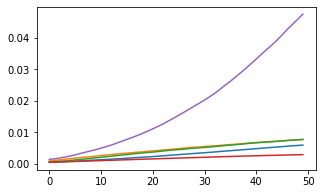

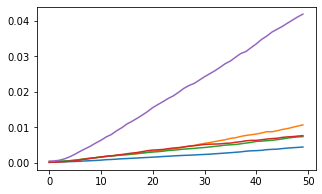

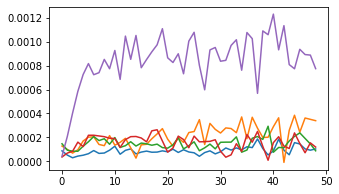

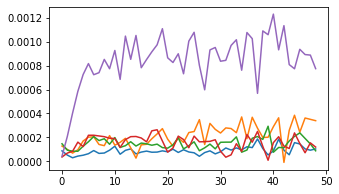

In [10]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(3):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/3
        sumss_b = sumss_b/3

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.019916035, 0.023337366, 0.025257053, 0.026708521, 0.028374579, 0.029833278, 0.031698078, 0.03371416, 0.035454564, 0.036887478, 0.038620826, 0.04056774, 0.041833512, 0.043439142, 0.04509148, 0.0462753, 0.047692653, 0.049153797, 0.050359186, 0.051539063, 0.052876744, 0.054133646, 0.05570524, 0.056923732, 0.058359668, 0.059752688, 0.06085484, 0.061811823, 0.06307806, 0.064215325, 0.065229595, 0.06646536, 0.06802541, 0.06926473, 0.070552394, 0.0717761, 0.07314936, 0.07440726, 0.0759992, 0.07711791, 0.07794348, 0.07913231, 0.08059093, 0.08163639, 0.082539834, 0.083692424, 0.08512536, 0.0860601, 0.08690714, 0.08777463]
[0.028252121, 0.032228965, 0.035759028, 0.038112998, 0.040863857, 0.044255998, 0.0476762, 0.05079705, 0.053034797, 0.055262193, 0.058392968, 0.060507953, 0.0628672, 0.06512362, 0.067006245, 0.067946345, 0.069906384, 0.07165117, 0.07351753, 0.07561445, 

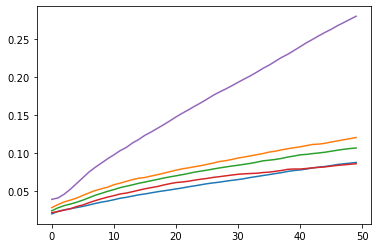

In [11]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

[[0.4432772994041443, 0.4432772994041443, 0.3172268867492676, 0.3382352888584137, 0.4789915978908539, 0.38445377349853516, 0.4495798349380493, 0.424369752407074, 0.38655462861061096, 0.36554622650146484, 0.3886554539203644, 0.43487393856048584, 0.3529411852359772, 0.40126049518585205, 0.38445377349853516, 0.30882352590560913, 0.4663865566253662, 0.41806721687316895, 0.4432772994041443, 0.3886554539203644], [0.27941176295280457, 0.26260504126548767, 0.24369747936725616, 0.27731093764305115, 0.2521008551120758, 0.22478991746902466, 0.24579831957817078, 0.22268907725811005, 0.25840336084365845, 0.24159663915634155, 0.2899159789085388, 0.27731093764305115, 0.24159663915634155, 0.26260504126548767, 0.3004201650619507, 0.2689075767993927, 0.3613445460796356, 0.2331932783126831, 0.1764705926179886, 0.1953781545162201], [0.26050421595573425, 0.3172268867492676, 0.28151261806488037, 0.3592436909675598, 0.34873950481414795, 0.2899159789085388, 0.3046218454837799, 0.3361344635486603, 0.3445378243

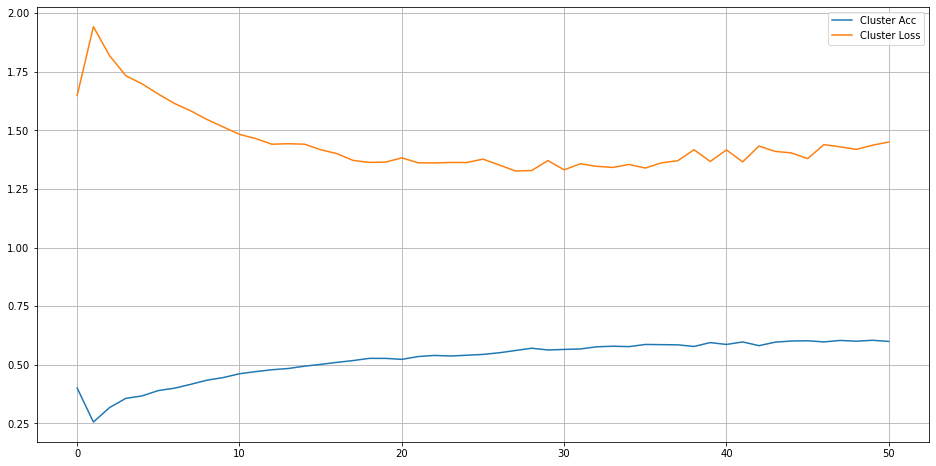

In [12]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()
